# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

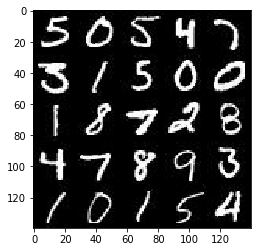

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

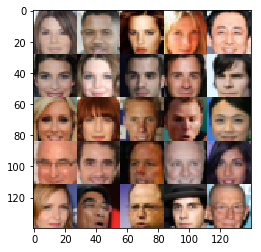

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None , image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [38]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True) 
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #Flatten 
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.5)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #drop = 0.5
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        #drop1 = tf.nn.dropout(relu1, drop)
        
        #256
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #drop2 = tf.nn.dropout(relu2, drop)
        
        #128
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #drop3 = tf.nn.dropout(relu3, drop)
        
        #Output
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same') 
        logits = tf.layers.dropout(logits, rate=0.5)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample, if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3 (for example).
    #Salimans et. al. 2016
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                #Normalize
                batch_images *= 2
                #Sample Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #Optimizer 
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate: learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2930... Generator Loss: 5.6524
Epoch 1/2... Discriminator Loss: 7.0897... Generator Loss: 8.8710
Epoch 1/2... Discriminator Loss: 0.8083... Generator Loss: 1.4981
Epoch 1/2... Discriminator Loss: 2.2214... Generator Loss: 2.1996
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 1.1160
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 1.0999
Epoch 1/2... Discriminator Loss: 1.7895... Generator Loss: 0.2724
Epoch 1/2... Discriminator Loss: 1.7148... Generator Loss: 0.2600
Epoch 1/2... Discriminator Loss: 1.8506... Generator Loss: 0.2163
Epoch 1/2... Discriminator Loss: 1.5224... Generator Loss: 0.3353


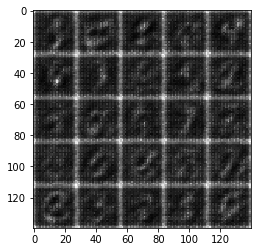

Epoch 1/2... Discriminator Loss: 1.7211... Generator Loss: 0.2732
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.3872
Epoch 1/2... Discriminator Loss: 1.8127... Generator Loss: 0.2266
Epoch 1/2... Discriminator Loss: 1.6542... Generator Loss: 0.3158
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.5269
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 1.4546
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 1.1944
Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 1.4334
Epoch 1/2... Discriminator Loss: 1.7088... Generator Loss: 0.2487


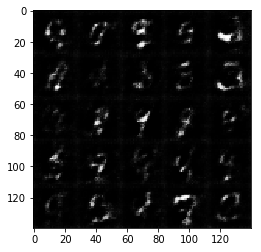

Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.4067
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.3966
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.5476
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.4628
Epoch 1/2... Discriminator Loss: 1.6552... Generator Loss: 0.2680
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 0.5354
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 0.7010
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 1.0303
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.2102
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 1.7112


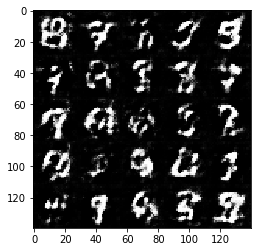

Epoch 1/2... Discriminator Loss: 0.9828... Generator Loss: 1.5685
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 0.9995
Epoch 1/2... Discriminator Loss: 0.8880... Generator Loss: 1.3132
Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 1.0376
Epoch 1/2... Discriminator Loss: 1.6906... Generator Loss: 0.2664
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.4862
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.4380
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 1.0600
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.2111


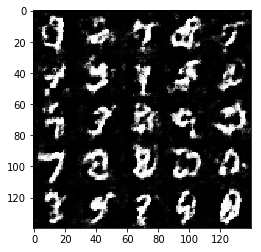

Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 0.9501
Epoch 1/2... Discriminator Loss: 1.5045... Generator Loss: 2.2487
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 1.0684
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 1.1106
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.4213
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.4194
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.8633... Generator Loss: 0.2323
Epoch 1/2... Discriminator Loss: 1.6581... Generator Loss: 0.2944
Epoch 1/2... Discriminator Loss: 1.5423... Generator Loss: 0.3649


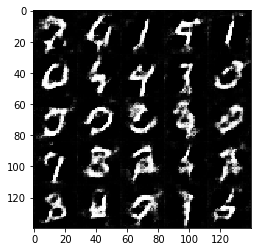

Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.4027
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 0.8233
Epoch 1/2... Discriminator Loss: 1.6636... Generator Loss: 0.2969
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 0.6735
Epoch 1/2... Discriminator Loss: 1.8750... Generator Loss: 0.2417
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 0.9547
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.6087
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 1.0368... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 1.4561


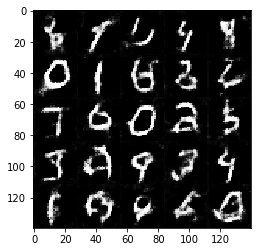

Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.3113
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.4478
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.4446
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.4129
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.5919
Epoch 1/2... Discriminator Loss: 0.9643... Generator Loss: 1.0045
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 1.7011... Generator Loss: 0.3105
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.1374


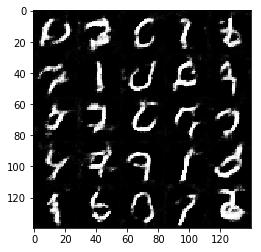

Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.3384
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.5487
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.4251
Epoch 1/2... Discriminator Loss: 1.5045... Generator Loss: 0.3306
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 1.9561
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 1.1104
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 0.7537


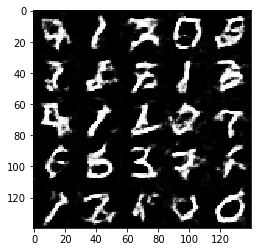

Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 0.3673
Epoch 1/2... Discriminator Loss: 1.3460... Generator Loss: 0.4834
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 0.5258
Epoch 1/2... Discriminator Loss: 1.8554... Generator Loss: 0.2389
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.4204
Epoch 1/2... Discriminator Loss: 1.0268... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 1.1830
Epoch 1/2... Discriminator Loss: 1.5601... Generator Loss: 0.3025
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 0.7040


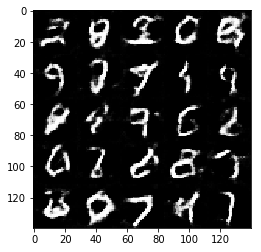

Epoch 1/2... Discriminator Loss: 1.5572... Generator Loss: 0.3132
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.2773
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 1.8008
Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 0.8773
Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 0.3265
Epoch 1/2... Discriminator Loss: 1.1822... Generator Loss: 0.5286
Epoch 1/2... Discriminator Loss: 1.4985... Generator Loss: 0.3694
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 1.7020


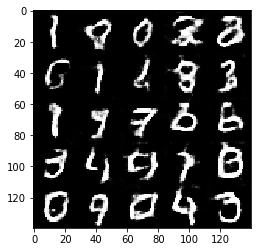

Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.5681
Epoch 1/2... Discriminator Loss: 1.9499... Generator Loss: 0.2141
Epoch 1/2... Discriminator Loss: 0.8306... Generator Loss: 1.1394
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.3045
Epoch 1/2... Discriminator Loss: 0.8494... Generator Loss: 1.6620
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.3219
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.0620
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.5020


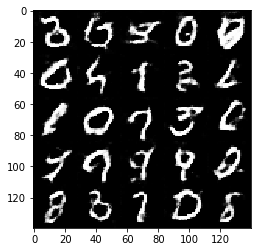

Epoch 1/2... Discriminator Loss: 4.3946... Generator Loss: 4.8849
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 0.4096
Epoch 1/2... Discriminator Loss: 0.8731... Generator Loss: 0.9307
Epoch 1/2... Discriminator Loss: 1.1490... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 1.2909
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 0.5182
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 2.5195... Generator Loss: 2.7855
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 0.5043


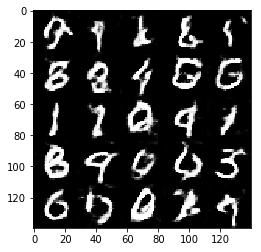

Epoch 1/2... Discriminator Loss: 1.7373... Generator Loss: 0.2675
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 0.5451
Epoch 1/2... Discriminator Loss: 0.8419... Generator Loss: 1.2479
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 1.8267
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 0.9002... Generator Loss: 0.8609
Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.6493
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 0.7144... Generator Loss: 1.3961
Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 0.9745


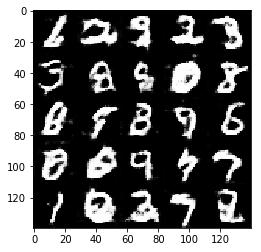

Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 1.5019... Generator Loss: 0.3749
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 1.1172
Epoch 1/2... Discriminator Loss: 0.5777... Generator Loss: 1.2961
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.3590
Epoch 1/2... Discriminator Loss: 2.5638... Generator Loss: 0.1469
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.4817
Epoch 1/2... Discriminator Loss: 1.6930... Generator Loss: 0.3044
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 0.6259


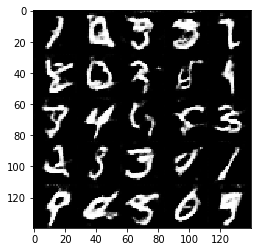

Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 0.5788
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.2370
Epoch 1/2... Discriminator Loss: 2.5138... Generator Loss: 0.1231
Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 0.6939
Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 0.5560
Epoch 1/2... Discriminator Loss: 0.7677... Generator Loss: 1.0183
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 1.7427... Generator Loss: 0.3080
Epoch 1/2... Discriminator Loss: 1.4725... Generator Loss: 0.3665
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.3890


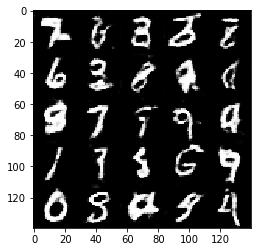

Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 0.5297
Epoch 1/2... Discriminator Loss: 2.5748... Generator Loss: 0.1699
Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 1.9562
Epoch 1/2... Discriminator Loss: 0.8599... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 2.0519
Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 0.3194
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.3413
Epoch 1/2... Discriminator Loss: 0.9098... Generator Loss: 1.0444


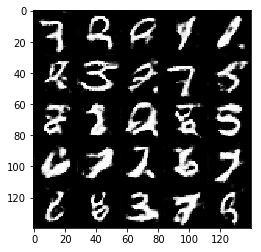

Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 1.0930
Epoch 1/2... Discriminator Loss: 2.3554... Generator Loss: 0.1607
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.5962... Generator Loss: 0.3212
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 2.6317... Generator Loss: 0.0996
Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 0.8937
Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 0.9889


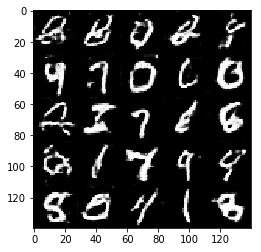

Epoch 1/2... Discriminator Loss: 1.7101... Generator Loss: 0.2931
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 0.5727
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.5942
Epoch 1/2... Discriminator Loss: 0.8179... Generator Loss: 1.4139
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.2056
Epoch 1/2... Discriminator Loss: 0.9209... Generator Loss: 0.7755
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.4339
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.5331
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 0.8717


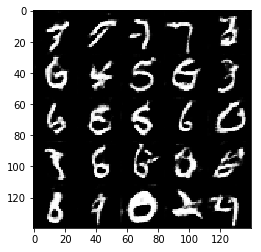

Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 0.9358
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 2.5346
Epoch 1/2... Discriminator Loss: 1.5194... Generator Loss: 0.3430
Epoch 1/2... Discriminator Loss: 1.6188... Generator Loss: 0.3165
Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 1.3367
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.5434
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 2.1242... Generator Loss: 0.2062
Epoch 2/2... Discriminator Loss: 1.6762... Generator Loss: 0.3327


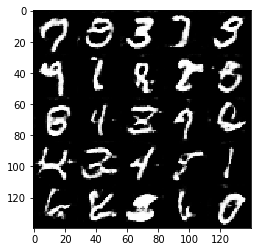

Epoch 2/2... Discriminator Loss: 1.0325... Generator Loss: 0.6699
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 1.9981
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.4167
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 1.1550... Generator Loss: 1.9987
Epoch 2/2... Discriminator Loss: 0.5412... Generator Loss: 1.3907
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 0.9836
Epoch 2/2... Discriminator Loss: 0.6617... Generator Loss: 1.6692


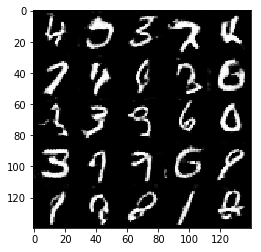

Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 2.6777
Epoch 2/2... Discriminator Loss: 0.9468... Generator Loss: 0.6544
Epoch 2/2... Discriminator Loss: 1.1901... Generator Loss: 0.5450
Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 0.8789... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 1.5041
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 0.8123... Generator Loss: 1.3151
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.2990
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 1.0420


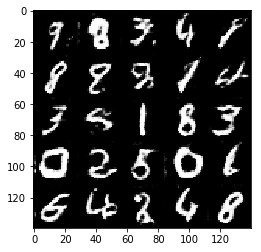

Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.3674
Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 1.9605
Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 0.6846... Generator Loss: 1.2045
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 0.6137
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 0.7262... Generator Loss: 1.2736
Epoch 2/2... Discriminator Loss: 0.8337... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 1.3065
Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 1.8821


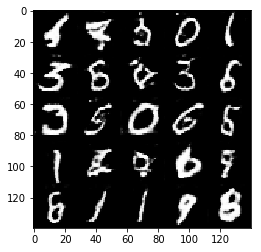

Epoch 2/2... Discriminator Loss: 0.5866... Generator Loss: 1.8802
Epoch 2/2... Discriminator Loss: 1.2908... Generator Loss: 1.8114
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 0.7298... Generator Loss: 1.1560
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.4819
Epoch 2/2... Discriminator Loss: 0.9485... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.4822
Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 0.9862
Epoch 2/2... Discriminator Loss: 0.8470... Generator Loss: 1.1760
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 0.5985


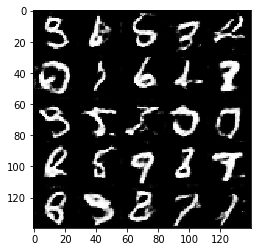

Epoch 2/2... Discriminator Loss: 2.2204... Generator Loss: 0.2438
Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 0.4538
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.4852
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 0.5496... Generator Loss: 1.6015
Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 3.1979
Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 0.5317... Generator Loss: 1.4590
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 2.5627


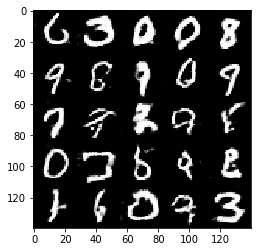

Epoch 2/2... Discriminator Loss: 0.6898... Generator Loss: 1.3176
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 1.5074
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 2.4778
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.5518
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 2.2959
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 1.0831
Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 1.2337
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 0.8473


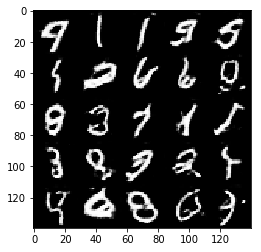

Epoch 2/2... Discriminator Loss: 0.9138... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 0.6572... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 0.9258... Generator Loss: 1.5844
Epoch 2/2... Discriminator Loss: 1.5232... Generator Loss: 2.7559
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.1431
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 2.0640
Epoch 2/2... Discriminator Loss: 0.8604... Generator Loss: 0.8342


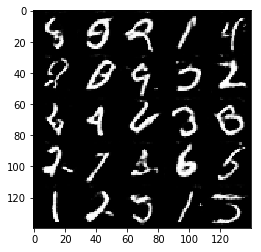

Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 1.7935
Epoch 2/2... Discriminator Loss: 0.7484... Generator Loss: 0.9575
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 0.8652
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 0.4488
Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 1.7852
Epoch 2/2... Discriminator Loss: 0.7845... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 2.4328
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 1.0393
Epoch 2/2... Discriminator Loss: 0.6337... Generator Loss: 1.3083
Epoch 2/2... Discriminator Loss: 0.7862... Generator Loss: 1.4780


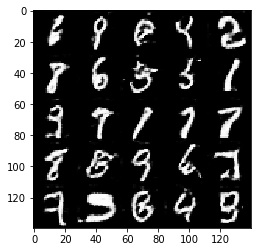

Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.0008
Epoch 2/2... Discriminator Loss: 0.6612... Generator Loss: 1.1649
Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.0971... Generator Loss: 2.0326
Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 2.0597
Epoch 2/2... Discriminator Loss: 0.5583... Generator Loss: 1.2860
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 2.3398
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 1.1735
Epoch 2/2... Discriminator Loss: 0.6065... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 0.9506


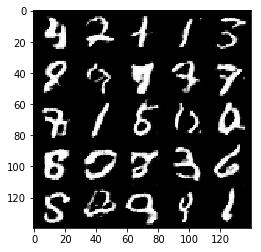

Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 2.2022
Epoch 2/2... Discriminator Loss: 1.7220... Generator Loss: 0.3273
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.4853
Epoch 2/2... Discriminator Loss: 0.6591... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 2.2938
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 1.2666
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 0.7768... Generator Loss: 0.8672
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.7223


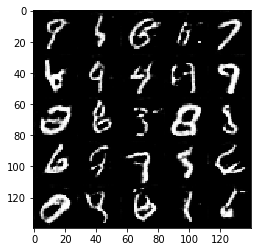

Epoch 2/2... Discriminator Loss: 0.9921... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.4452
Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 0.6598... Generator Loss: 1.0373
Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 1.2442
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 2.6172
Epoch 2/2... Discriminator Loss: 0.6468... Generator Loss: 1.3946
Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 0.7041... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 1.5380... Generator Loss: 0.4526


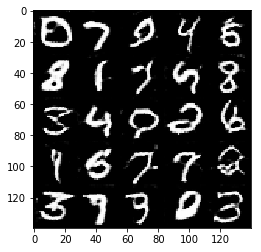

Epoch 2/2... Discriminator Loss: 0.6599... Generator Loss: 1.5604
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 1.1201... Generator Loss: 0.5241
Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 0.8800
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 1.8310
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 1.4656
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.4544
Epoch 2/2... Discriminator Loss: 1.9857... Generator Loss: 0.2201
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.5135
Epoch 2/2... Discriminator Loss: 0.4670... Generator Loss: 1.4725


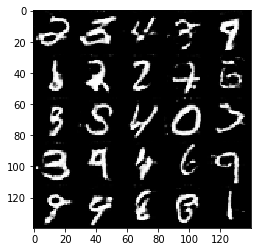

Epoch 2/2... Discriminator Loss: 1.7546... Generator Loss: 0.2611
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 1.8700
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.9809
Epoch 2/2... Discriminator Loss: 0.5848... Generator Loss: 1.4825
Epoch 2/2... Discriminator Loss: 0.8253... Generator Loss: 0.8749
Epoch 2/2... Discriminator Loss: 0.5368... Generator Loss: 1.5182
Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 1.7207... Generator Loss: 0.3269


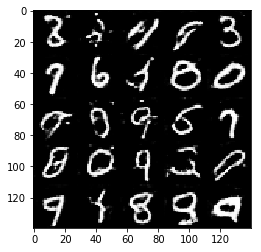

Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 1.6785
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 0.5469... Generator Loss: 1.3253
Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 0.6466... Generator Loss: 1.2432
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 1.0720
Epoch 2/2... Discriminator Loss: 0.4557... Generator Loss: 1.7035
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.5764
Epoch 2/2... Discriminator Loss: 0.7827... Generator Loss: 0.9549


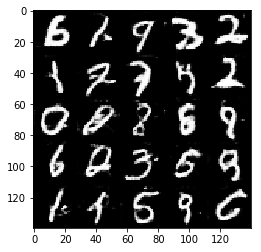

Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 1.1527
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.5734
Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 1.7926
Epoch 2/2... Discriminator Loss: 0.6530... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 0.7484
Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 1.0731
Epoch 2/2... Discriminator Loss: 1.8300... Generator Loss: 0.2485
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 2.3263
Epoch 2/2... Discriminator Loss: 0.5094... Generator Loss: 1.3707


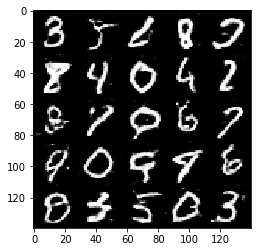

Epoch 2/2... Discriminator Loss: 0.4602... Generator Loss: 1.8656
Epoch 2/2... Discriminator Loss: 0.4678... Generator Loss: 1.6421
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 2.3471
Epoch 2/2... Discriminator Loss: 0.4496... Generator Loss: 1.8272
Epoch 2/2... Discriminator Loss: 0.4767... Generator Loss: 1.4079
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 1.1138
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 0.5686
Epoch 2/2... Discriminator Loss: 1.0530... Generator Loss: 0.6578
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 0.6866


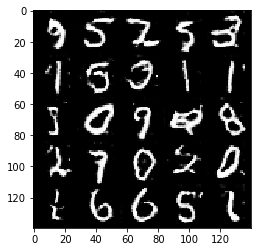

Epoch 2/2... Discriminator Loss: 0.7187... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 0.5662... Generator Loss: 2.7688
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 0.6059
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 0.8608
Epoch 2/2... Discriminator Loss: 0.4455... Generator Loss: 1.8332
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.9298
Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 0.5768
Epoch 2/2... Discriminator Loss: 0.3480... Generator Loss: 1.9758
Epoch 2/2... Discriminator Loss: 0.5884... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 1.8927... Generator Loss: 3.3736


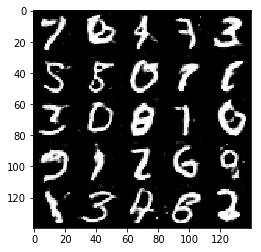

Epoch 2/2... Discriminator Loss: 2.7593... Generator Loss: 0.1058
Epoch 2/2... Discriminator Loss: 0.6214... Generator Loss: 1.1330
Epoch 2/2... Discriminator Loss: 1.1299... Generator Loss: 0.5998
Epoch 2/2... Discriminator Loss: 0.6470... Generator Loss: 1.6414
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.4343
Epoch 2/2... Discriminator Loss: 1.5326... Generator Loss: 0.3759
Epoch 2/2... Discriminator Loss: 1.6817... Generator Loss: 0.2903
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 0.8521
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 0.5394
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 0.9049


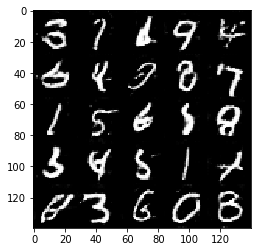

Epoch 2/2... Discriminator Loss: 0.5880... Generator Loss: 1.1983
Epoch 2/2... Discriminator Loss: 0.5156... Generator Loss: 1.3129
Epoch 2/2... Discriminator Loss: 0.7953... Generator Loss: 0.8642
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.5280
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 0.6594


In [40]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3573... Generator Loss: 0.1144
Epoch 1/1... Discriminator Loss: 4.5795... Generator Loss: 0.0124
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 6.2918
Epoch 1/1... Discriminator Loss: 3.6149... Generator Loss: 0.0350
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 1.9404
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.8800... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 2.0198
Epoch 1/1... Discriminator Loss: 0.0945... Generator Loss: 2.4261


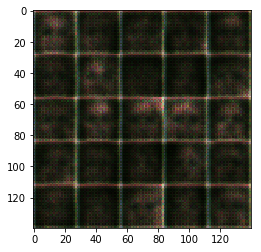

Epoch 1/1... Discriminator Loss: 1.7908... Generator Loss: 5.7808
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 3.0106
Epoch 1/1... Discriminator Loss: 0.2601... Generator Loss: 2.6057
Epoch 1/1... Discriminator Loss: 1.7584... Generator Loss: 0.2456
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 2.1524... Generator Loss: 0.1814
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 2.5531
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.3711


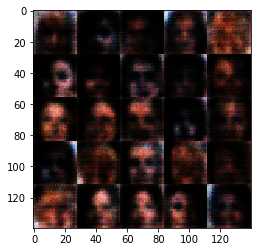

Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 3.0621
Epoch 1/1... Discriminator Loss: 0.4197... Generator Loss: 2.4734
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 2.5849
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 1.6299
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 2.9095
Epoch 1/1... Discriminator Loss: 0.3174... Generator Loss: 5.1725
Epoch 1/1... Discriminator Loss: 0.0966... Generator Loss: 2.3752
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.3035


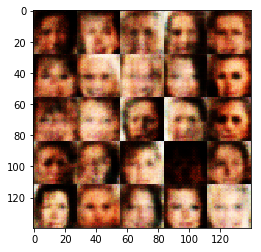

Epoch 1/1... Discriminator Loss: 0.1471... Generator Loss: 2.0470
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 4.7950
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 2.9149
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 3.3641
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 4.2091
Epoch 1/1... Discriminator Loss: 1.7202... Generator Loss: 3.7541
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 4.2514
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 1.7822
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 3.4550


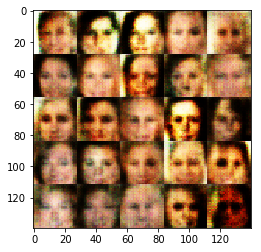

Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.8804
Epoch 1/1... Discriminator Loss: 2.2743... Generator Loss: 0.1251
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 0.2046... Generator Loss: 1.9100
Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 0.2092
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 4.0858
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 3.4844
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 3.0965
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 0.1326... Generator Loss: 2.2495


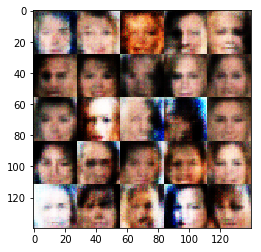

Epoch 1/1... Discriminator Loss: 0.1233... Generator Loss: 4.1056
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 2.6540... Generator Loss: 0.0843
Epoch 1/1... Discriminator Loss: 0.2271... Generator Loss: 1.7284
Epoch 1/1... Discriminator Loss: 2.3685... Generator Loss: 0.1187
Epoch 1/1... Discriminator Loss: 0.1848... Generator Loss: 2.5805
Epoch 1/1... Discriminator Loss: 0.2019... Generator Loss: 2.4749
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.2772


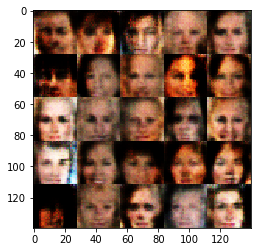

Epoch 1/1... Discriminator Loss: 0.3063... Generator Loss: 1.5751
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.3977
Epoch 1/1... Discriminator Loss: 1.9476... Generator Loss: 0.1849
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 4.4650
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 3.1230
Epoch 1/1... Discriminator Loss: 0.2607... Generator Loss: 2.7059
Epoch 1/1... Discriminator Loss: 2.0843... Generator Loss: 0.1557
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.3401
Epoch 1/1... Discriminator Loss: 0.1150... Generator Loss: 2.5437


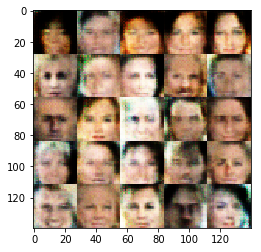

Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 0.1366... Generator Loss: 3.6771
Epoch 1/1... Discriminator Loss: 0.1092... Generator Loss: 3.4721
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 3.1474
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.2717
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 1.9672
Epoch 1/1... Discriminator Loss: 0.0372... Generator Loss: 3.5210
Epoch 1/1... Discriminator Loss: 0.3162... Generator Loss: 4.8026
Epoch 1/1... Discriminator Loss: 2.1254... Generator Loss: 0.1371
Epoch 1/1... Discriminator Loss: 2.1737... Generator Loss: 0.1525


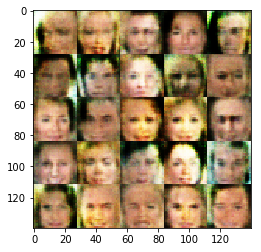

Epoch 1/1... Discriminator Loss: 0.3087... Generator Loss: 1.8273
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.3214
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 3.4633
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 3.1848
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.7515
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.3217
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 0.2172... Generator Loss: 2.1232
Epoch 1/1... Discriminator Loss: 2.0390... Generator Loss: 0.1582


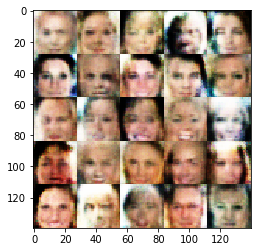

Epoch 1/1... Discriminator Loss: 0.2829... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 1.6564
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.6758... Generator Loss: 0.2974
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 2.0748
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 0.1024... Generator Loss: 2.4763


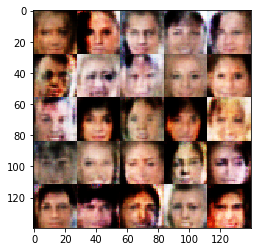

Epoch 1/1... Discriminator Loss: 0.3041... Generator Loss: 4.1876
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 3.7290
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 2.1512
Epoch 1/1... Discriminator Loss: 0.1192... Generator Loss: 2.4276
Epoch 1/1... Discriminator Loss: 0.0784... Generator Loss: 4.2179
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 2.1196
Epoch 1/1... Discriminator Loss: 0.4676... Generator Loss: 3.6859


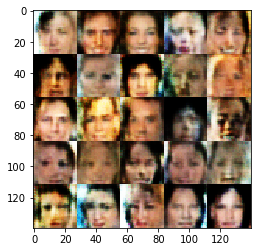

Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.3431
Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 1.3190
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 2.1289
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 3.1285
Epoch 1/1... Discriminator Loss: 3.5848... Generator Loss: 3.8472
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 2.6637
Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 2.6602


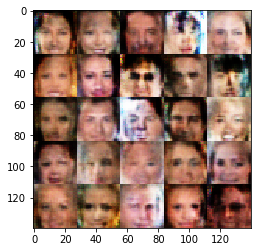

Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 3.6371
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 1.7962
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 2.2112
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 3.0798... Generator Loss: 0.0507
Epoch 1/1... Discriminator Loss: 0.2351... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 3.1134
Epoch 1/1... Discriminator Loss: 0.1770... Generator Loss: 1.8687
Epoch 1/1... Discriminator Loss: 0.3004... Generator Loss: 1.3267


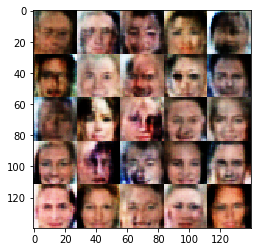

Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 3.5304
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 0.2073... Generator Loss: 2.7865
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 2.3665
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 2.6233
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.3921
Epoch 1/1... Discriminator Loss: 0.0991... Generator Loss: 2.7000
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 2.7128
Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 1.3005


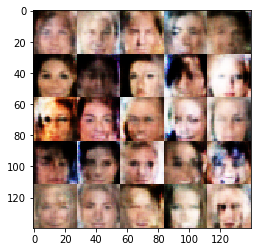

Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 3.5736
Epoch 1/1... Discriminator Loss: 2.9063... Generator Loss: 0.0644
Epoch 1/1... Discriminator Loss: 0.2263... Generator Loss: 1.6453
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 4.4069
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.4334
Epoch 1/1... Discriminator Loss: 0.1633... Generator Loss: 1.9314
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 4.0104
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 2.6574
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 0.7904


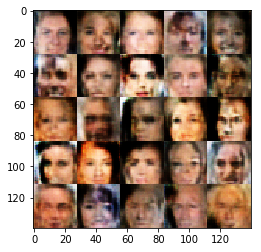

Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.3447
Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 2.5369
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 3.1367
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 0.2420... Generator Loss: 3.8037
Epoch 1/1... Discriminator Loss: 0.2065... Generator Loss: 3.5450
Epoch 1/1... Discriminator Loss: 0.2569... Generator Loss: 2.3408
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.9584
Epoch 1/1... Discriminator Loss: 0.1554... Generator Loss: 2.2302
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 0.5327


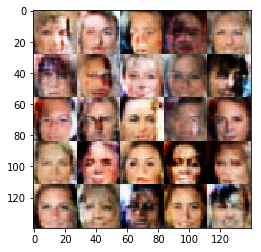

Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 1.2752
Epoch 1/1... Discriminator Loss: 0.1413... Generator Loss: 2.3807
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 4.3820
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 1.4997
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.3628
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.6182
Epoch 1/1... Discriminator Loss: 0.2274... Generator Loss: 1.8372


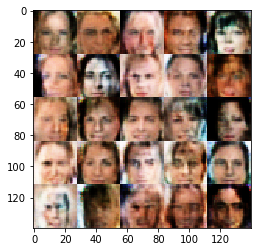

Epoch 1/1... Discriminator Loss: 1.7296... Generator Loss: 0.2645
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 1.9083
Epoch 1/1... Discriminator Loss: 0.2701... Generator Loss: 1.9681
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 0.0884... Generator Loss: 2.6021
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.0517


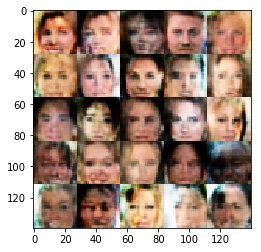

Epoch 1/1... Discriminator Loss: 0.2518... Generator Loss: 2.1243
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.9166
Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 2.5179
Epoch 1/1... Discriminator Loss: 0.2756... Generator Loss: 1.6366
Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.5270
Epoch 1/1... Discriminator Loss: 0.2147... Generator Loss: 4.3430
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.5090


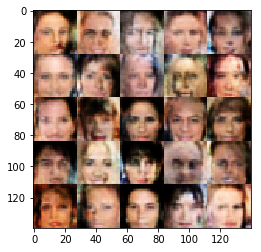

Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.3120
Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 1.7565
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.4040
Epoch 1/1... Discriminator Loss: 2.0915... Generator Loss: 0.1392
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 2.8294
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 3.8208
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 0.2489... Generator Loss: 3.2867
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 0.6137


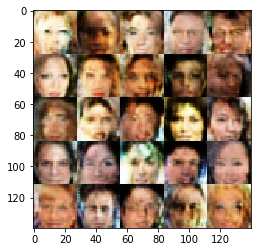

Epoch 1/1... Discriminator Loss: 1.5978... Generator Loss: 0.2476
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.3869
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 0.2053... Generator Loss: 1.6802
Epoch 1/1... Discriminator Loss: 0.3391... Generator Loss: 1.5357
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 2.3860
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 0.9196


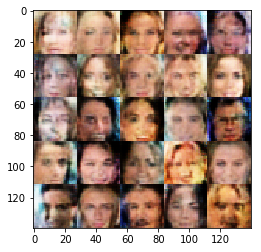

Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 2.0234
Epoch 1/1... Discriminator Loss: 0.3211... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 2.5018
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 1.8109
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 1.8716
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.9247
Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 2.4199


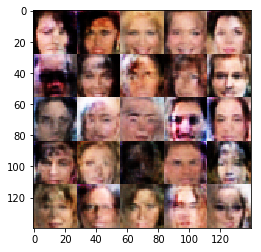

Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 0.2459... Generator Loss: 2.1364
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 0.3486... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 3.0014... Generator Loss: 0.0580
Epoch 1/1... Discriminator Loss: 1.9398... Generator Loss: 2.4485
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 2.2238
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.6916... Generator Loss: 0.2753


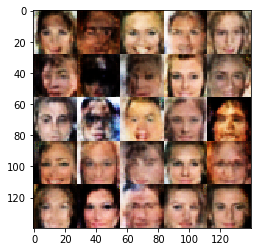

Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 2.7326
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 2.0880
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 2.6085
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 1.5259
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 2.7096
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 2.0081
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.4459


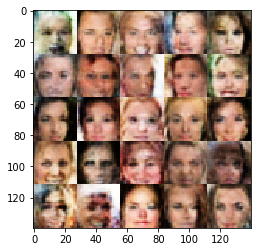

Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 2.2199... Generator Loss: 0.1307
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.2911
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 1.4008
Epoch 1/1... Discriminator Loss: 1.8787... Generator Loss: 0.1714
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 0.3026... Generator Loss: 1.6623
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 1.7608


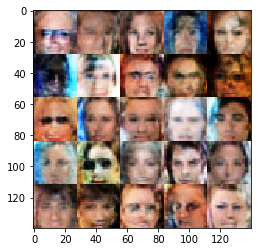

Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.7585... Generator Loss: 0.2087
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 2.6135
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 0.1118... Generator Loss: 2.7383
Epoch 1/1... Discriminator Loss: 1.9697... Generator Loss: 0.1817
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 2.3891
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 2.0950
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 0.7768


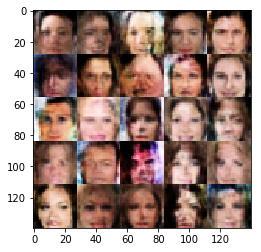

Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.5229
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 3.1247
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.2484
Epoch 1/1... Discriminator Loss: 1.8109... Generator Loss: 2.1263
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 0.1993... Generator Loss: 2.8570
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 2.2582
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 0.6949


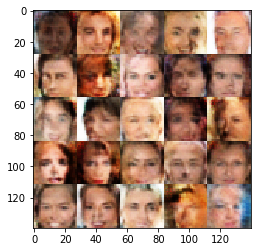

Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 0.5488... Generator Loss: 2.1151
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.3774
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 0.1556... Generator Loss: 2.0741
Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 3.0957


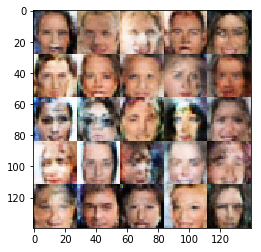

Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 1.5200
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.7530
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.2468
Epoch 1/1... Discriminator Loss: 1.7813... Generator Loss: 0.2057
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 2.3001
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 2.0861


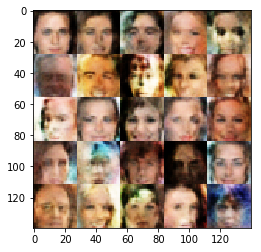

Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.3797
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 2.0451
Epoch 1/1... Discriminator Loss: 0.3216... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 0.2191... Generator Loss: 2.1205
Epoch 1/1... Discriminator Loss: 1.7641... Generator Loss: 0.2114
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.2906


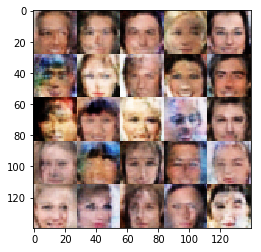

Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 2.8384
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 2.1358... Generator Loss: 0.1365
Epoch 1/1... Discriminator Loss: 1.8580... Generator Loss: 0.2106
Epoch 1/1... Discriminator Loss: 0.1557... Generator Loss: 2.2613
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 0.3152... Generator Loss: 1.4813
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.5094


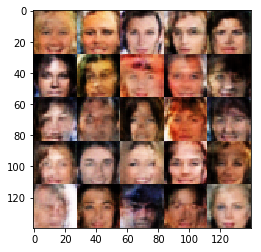

Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 1.6274
Epoch 1/1... Discriminator Loss: 0.2744... Generator Loss: 1.5927
Epoch 1/1... Discriminator Loss: 0.2797... Generator Loss: 1.6548
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.4320
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 2.8148
Epoch 1/1... Discriminator Loss: 1.7721... Generator Loss: 0.1906
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.2542


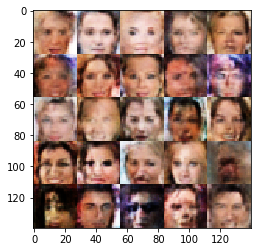

Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 0.2949... Generator Loss: 2.0114
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 1.2476


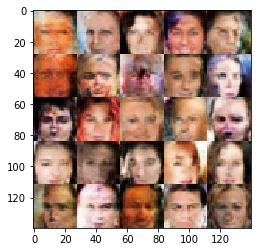

Epoch 1/1... Discriminator Loss: 1.8902... Generator Loss: 0.2525
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 1.3135
Epoch 1/1... Discriminator Loss: 0.3147... Generator Loss: 2.2271
Epoch 1/1... Discriminator Loss: 2.2891... Generator Loss: 0.1385
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 2.0056... Generator Loss: 0.1649
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.3431
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 0.9723


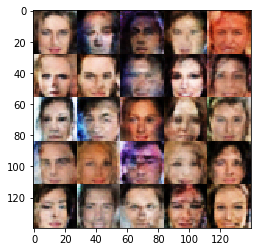

Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 1.7872
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 0.2616... Generator Loss: 2.5490
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.8054... Generator Loss: 0.1962
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 2.0529
Epoch 1/1... Discriminator Loss: 1.9223... Generator Loss: 0.1833


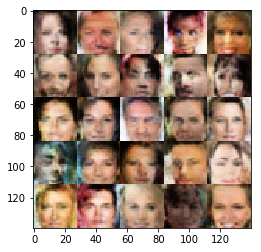

Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 2.0645
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.2811
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.2394
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.7669... Generator Loss: 0.2557
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.9041... Generator Loss: 0.1903
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9518


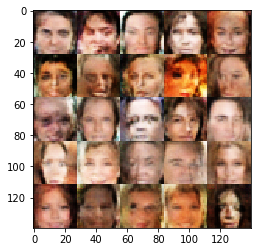

Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 1.4630
Epoch 1/1... Discriminator Loss: 1.7474... Generator Loss: 0.2153
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 1.6921
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.5781
Epoch 1/1... Discriminator Loss: 0.3201... Generator Loss: 2.0808
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 0.9919


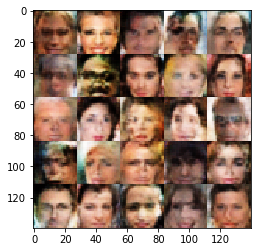

Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 0.1680
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 1.7073
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.3316
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.3497
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.2792
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.5354


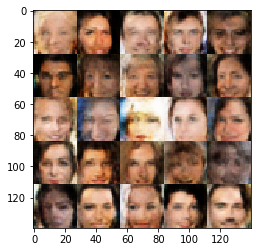

Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.2897
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.2713
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.3453
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.2853
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 1.8986
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.3231
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 0.5405


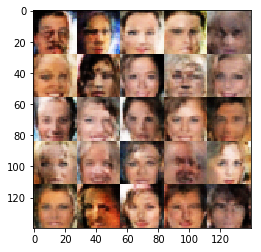

Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.3927
Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 1.6808
Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.5929
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.1813
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 1.3685


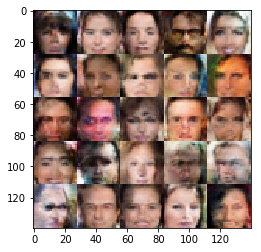

Epoch 1/1... Discriminator Loss: 2.0038... Generator Loss: 0.1693
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.2604... Generator Loss: 2.0715
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 1.6956
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.3719
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.3772
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.0985


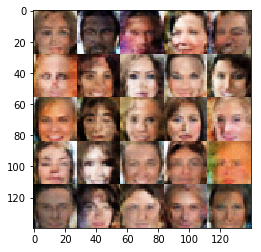

Epoch 1/1... Discriminator Loss: 1.8236... Generator Loss: 0.2009
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.3477
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 2.0359
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 0.6528


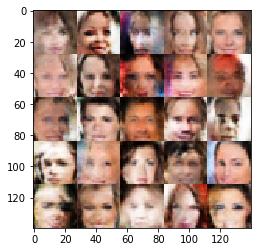

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.3308
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 2.0103
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.9052
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 1.7698
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.2888


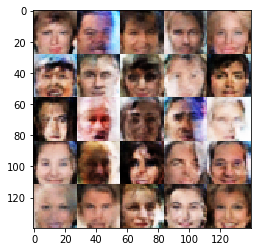

Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.2448
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 1.8228
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 1.7620... Generator Loss: 0.2089
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.3011
Epoch 1/1... Discriminator Loss: 1.7706... Generator Loss: 0.2233
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.3355
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.2274


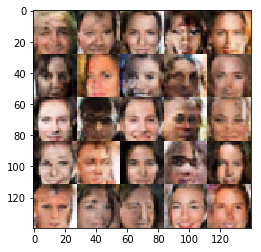

Epoch 1/1... Discriminator Loss: 2.1373... Generator Loss: 0.1472
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.2452
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.2532
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.4109
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 1.5789


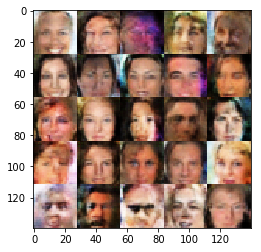

Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.5165
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.3066
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.3875


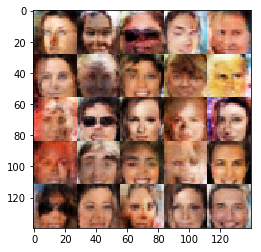

Epoch 1/1... Discriminator Loss: 1.7307... Generator Loss: 0.2067
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 2.1550... Generator Loss: 0.1340
Epoch 1/1... Discriminator Loss: 2.3098... Generator Loss: 0.1226
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.3428
Epoch 1/1... Discriminator Loss: 2.1947... Generator Loss: 0.1374
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.4230


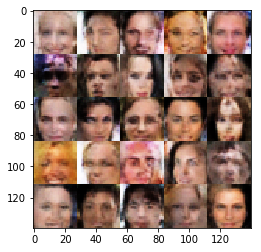

Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 1.8073
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 1.6263
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 1.6566
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.3015
Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.2363
Epoch 1/1... Discriminator Loss: 2.4332... Generator Loss: 0.1234


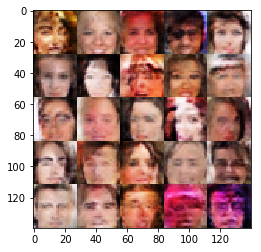

Epoch 1/1... Discriminator Loss: 1.6801... Generator Loss: 0.2264
Epoch 1/1... Discriminator Loss: 2.1996... Generator Loss: 0.1368
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.3299
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.3344
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.2893
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.2782
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 1.5570
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.8972


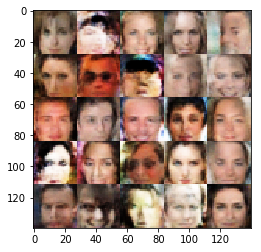

Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.2018
Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.7572... Generator Loss: 0.2050
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 2.1146... Generator Loss: 0.1569
Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 1.7649
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 0.8712


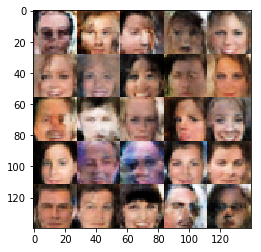

Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.9508... Generator Loss: 0.1716
Epoch 1/1... Discriminator Loss: 1.8985... Generator Loss: 0.1789
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 0.9866


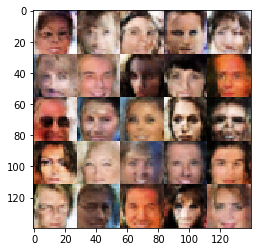

Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.1944
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.2261
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 0.7693


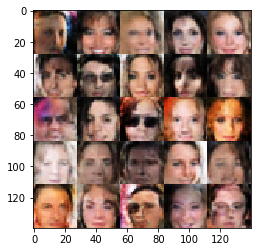

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.4362
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 2.3356
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.2486
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 2.1737... Generator Loss: 0.1290
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.7518


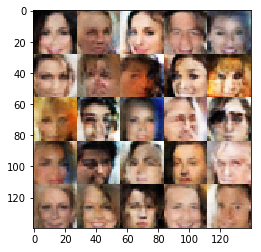

Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.2744
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 2.0148... Generator Loss: 0.1563
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.2877
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 0.8875


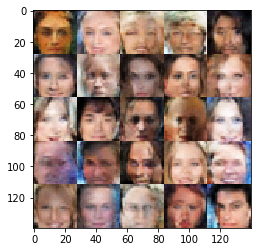

Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.2852
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.3968
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.9467... Generator Loss: 0.1612
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.8971... Generator Loss: 1.1917


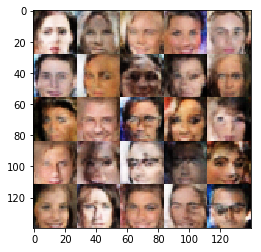

Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 1.8949... Generator Loss: 0.1849
Epoch 1/1... Discriminator Loss: 1.8734... Generator Loss: 0.1981
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.1139
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.8960


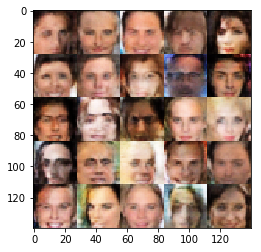

Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 2.9420
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 1.2041


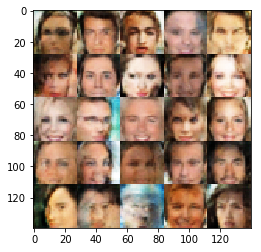

Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.8639
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 2.1846... Generator Loss: 0.1336


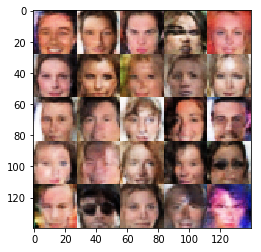

Epoch 1/1... Discriminator Loss: 1.7680... Generator Loss: 0.2068
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.5759
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.4866
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 0.8820


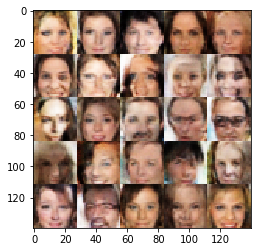

Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.2802
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.8552... Generator Loss: 0.1925
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 2.0840
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.3342
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.5611


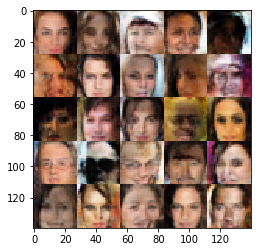

Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.7748... Generator Loss: 0.1942
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.2892
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 1.7665... Generator Loss: 0.2075
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 1.4448


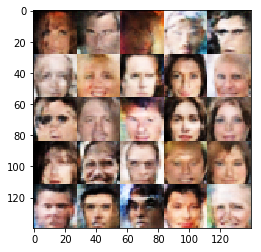

Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.3008
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.2435
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.8176... Generator Loss: 0.2015
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.4957
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.4086


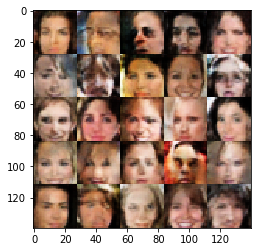

Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 1.9063
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.4156
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.2807
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.3843
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.3308


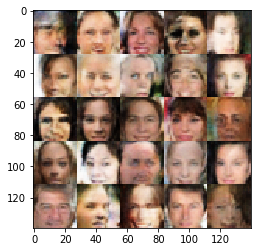

Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.0585


In [39]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.